Success Rate: 99.00%
Average Reward per Episode: 7.68
Average Learning Speed (ALS): 0.08


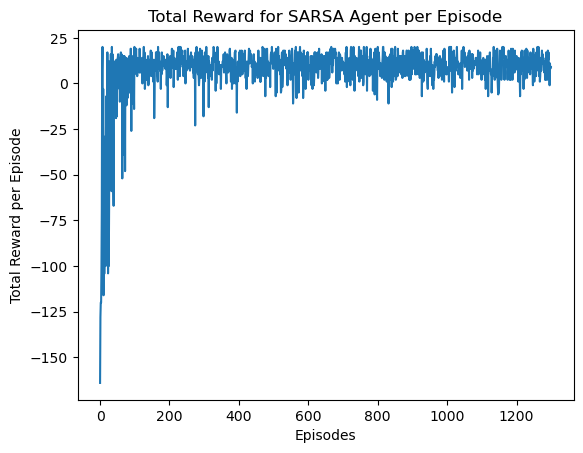

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from env import StaticGridEnv

# SARSA parameters
alpha = 0.7  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 1300  # Number of episodes for training
max_steps_per_episode = 100  # Max steps per episode

# Initialize the environment
env = StaticGridEnv(seed=42)
q_table = np.zeros((env.grid_size, env.grid_size, env.action_space))  # Q-table

# Metrics tracking
total_rewards = []  # Total rewards per episode
steps_per_episode = []  # Steps taken per episode
successful_episodes = 0  # Number of successful episodes (goal reached)

# SARSA algorithm
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0

    # Choose initial action using epsilon-greedy policy
    if np.random.rand() < epsilon:
        action = np.random.randint(env.action_space)
    else:
        action = np.argmax(q_table[state[0], state[1]])

    for step in range(max_steps_per_episode):
        # Take the action and observe the outcome
        next_state, reward, done, _ = env.step(action)

        # Choose next action using epsilon-greedy policy
        if np.random.rand() < epsilon:
            next_action = np.random.randint(env.action_space)
        else:
            next_action = np.argmax(q_table[next_state[0], next_state[1]])

        # SARSA update rule
        q_table[state[0], state[1], action] += alpha * (
            reward + gamma * q_table[next_state[0], next_state[1], next_action] - q_table[state[0], state[1], action]
        )

        # Update the current state and action
        state, action = next_state, next_action
        total_reward += reward

        # If goal is reached, end the episode
        if done:
            successful_episodes += 1
            break

    # Track metrics
    total_rewards.append(total_reward)
    steps_per_episode.append(step + 1)

# Save the trained Q-table for future use (for Task 4 or analysis)
np.save("sarsa_teacher_q_table.npy", q_table)

# Calculate and display performance metrics
success_rate = (successful_episodes / num_episodes) * 100
average_reward = np.mean(total_rewards)
average_learning_speed = 1 / np.mean(steps_per_episode)

print(f"Success Rate: {success_rate:.2f}%")
print(f"Average Reward per Episode: {average_reward:.2f}")
print(f"Average Learning Speed (ALS): {average_learning_speed:.2f}")

# Plot total reward per episode
plt.plot(total_rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Reward per Episode")
plt.title("Total Reward for SARSA Agent per Episode")
plt.show()

# Close the environment
env.close()


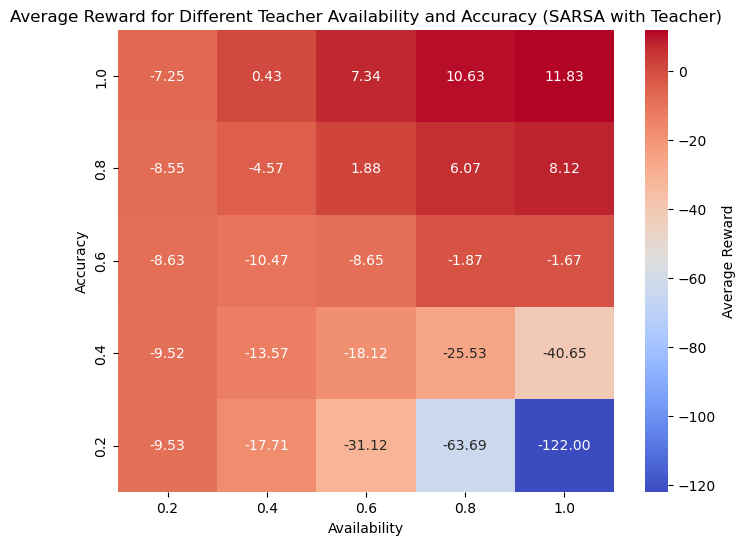

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from env import StaticGridEnv

# Load the SARSA-trained teacher Q-table
teacher_q_table = np.load("sarsa_teacher_q_table.npy")

# SARSA parameters for the student agent
alpha = 0.1
gamma = 0.9
initial_epsilon = 0.1
epsilon_decay = 0.995
min_epsilon = 0.01
num_episodes = 500
max_steps_per_episode = 100

# Teacher parameters
availability_values = [0.2, 0.4, 0.6, 0.8, 1.0]
accuracy_values = [0.2, 0.4, 0.6, 0.8, 1.0]

# Initialize environment
env = StaticGridEnv(seed=42)

# Define the function to provide teacher advice
def provide_teacher_advice(teacher_q_table, current_state, availability, accuracy):
    if np.random.rand() < availability:
        if np.random.rand() < accuracy:
            # Provide correct advice
            correct_action = np.argmax(teacher_q_table[current_state[0], current_state[1]])
            return correct_action
        else:
            # Provide incorrect advice
            correct_action = np.argmax(teacher_q_table[current_state[0], current_state[1]])
            possible_actions = list(range(teacher_q_table.shape[2]))
            possible_actions.remove(correct_action)
            return np.random.choice(possible_actions)
    return None  # No advice given

# Function to train the SARSA student agent with teacher advice
def train_sarsa_student_with_teacher(availability, accuracy):
    q_table = np.zeros((env.grid_size, env.grid_size, env.action_space))
    epsilon = initial_epsilon
    total_rewards = []
    steps_per_episode = []
    successful_episodes = 0

    for episode in range(num_episodes):
        state = env.reset()
        # Initial action selection with epsilon-greedy policy
        if np.random.rand() < epsilon:
            action = np.random.randint(env.action_space)
        else:
            action = np.argmax(q_table[state[0], state[1]])

        total_reward = 0
        for step in range(max_steps_per_episode):
            # Get teacher advice
            teacher_advice = provide_teacher_advice(teacher_q_table, state, availability, accuracy)
            if teacher_advice is not None:
                action = teacher_advice  # Follow teacher's advice if given

            # Take the action and observe the outcome
            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Choose next action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                next_action = np.random.randint(env.action_space)
            else:
                next_action = np.argmax(q_table[next_state[0], next_state[1]])

            # SARSA update rule
            q_table[state[0], state[1], action] += alpha * (
                reward + gamma * q_table[next_state[0], next_state[1], next_action] - q_table[state[0], state[1], action]
            )

            state, action = next_state, next_action

            if done:
                successful_episodes += 1
                break

        # Decay epsilon
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Track metrics
        total_rewards.append(total_reward)
        steps_per_episode.append(step + 1)

    # Calculate performance metrics
    success_rate = (successful_episodes / num_episodes) * 100
    avg_reward = np.mean(total_rewards)
    avg_learning_speed = 1 / np.mean(steps_per_episode)

    return avg_reward, success_rate, avg_learning_speed

# Run experiments and collect results
results = []
for availability in availability_values:
    for accuracy in accuracy_values:
        avg_reward, success_rate, avg_learning_speed = train_sarsa_student_with_teacher(availability, accuracy)
        results.append({
            "Availability": availability,
            "Accuracy": accuracy,
            "Average Reward": avg_reward,
            "Success Rate": success_rate,
            "Average Learning Speed": avg_learning_speed
        })

# Convert results to DataFrame for analysis
df_results = pd.DataFrame(results)

# Create a pivot table for heatmap using Average Reward
heatmap_data = df_results.pivot(index="Accuracy", columns="Availability", values="Average Reward")
heatmap_data = heatmap_data.sort_index(ascending=False)  # Sort Accuracy in descending order for y-axis

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Average Reward'}
)
plt.title("Average Reward for Different Teacher Availability and Accuracy (SARSA with Teacher)")
plt.xlabel("Availability")
plt.ylabel("Accuracy")
plt.show()
